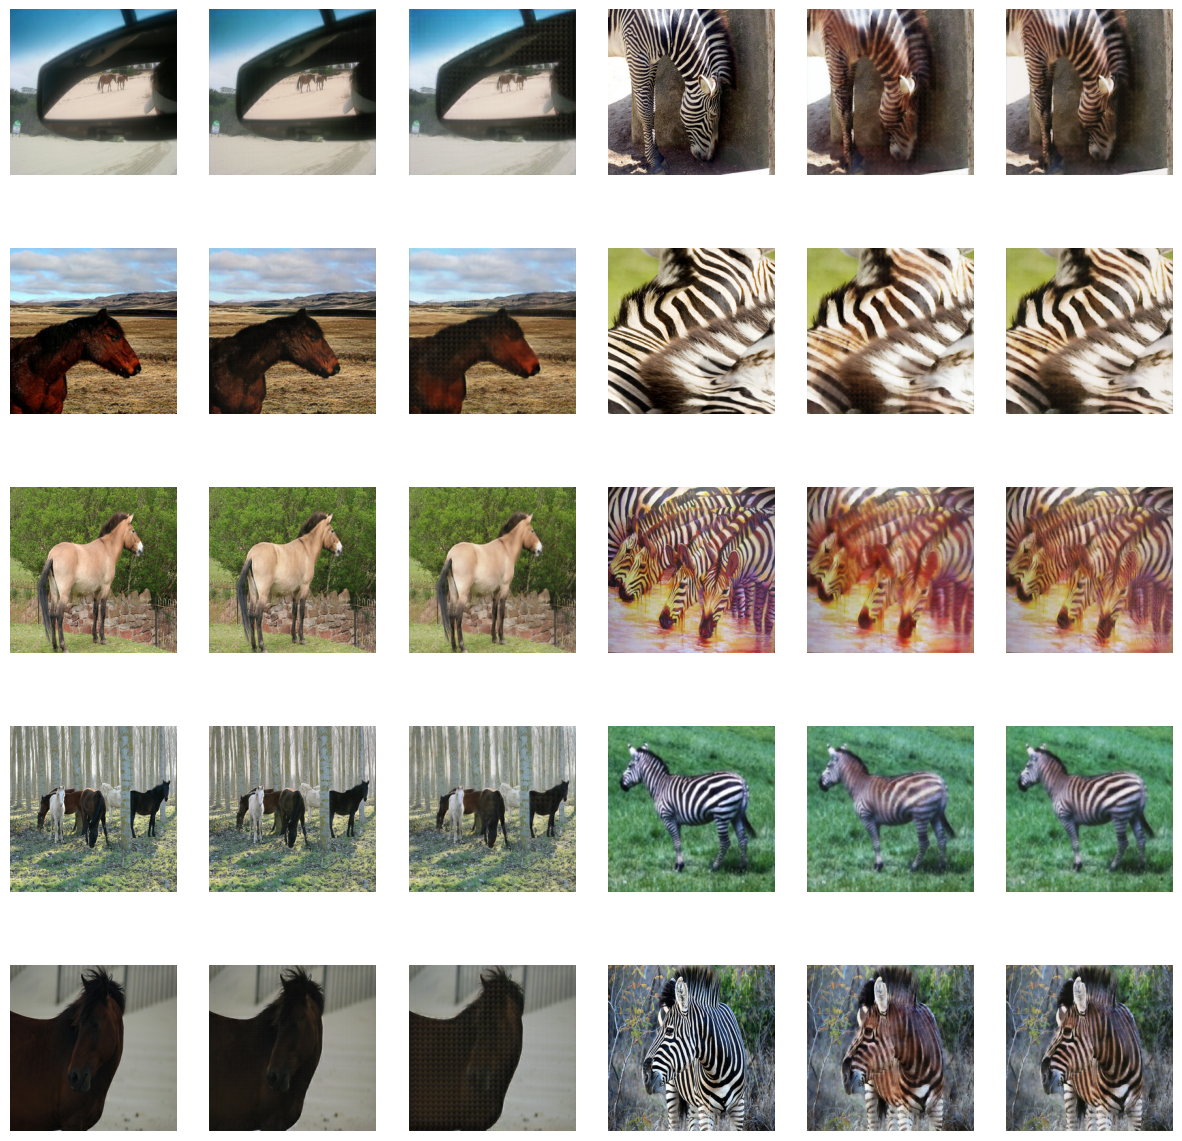

Epoch 50: G Loss: 4.8834, F Loss: 4.4470, D_X Loss: 0.2139, D_Y Loss: 0.9503


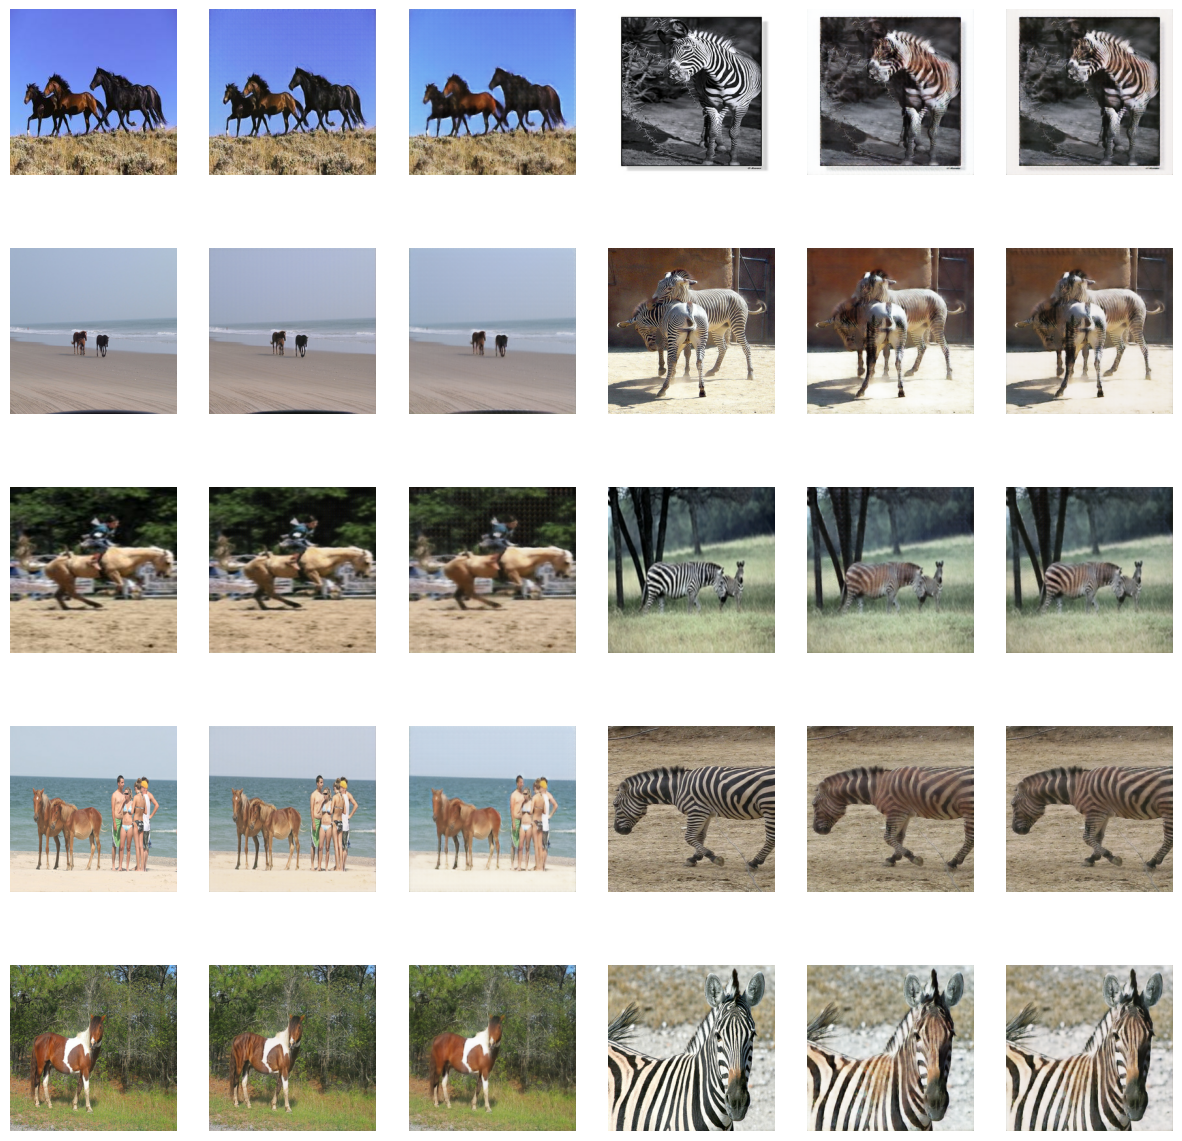

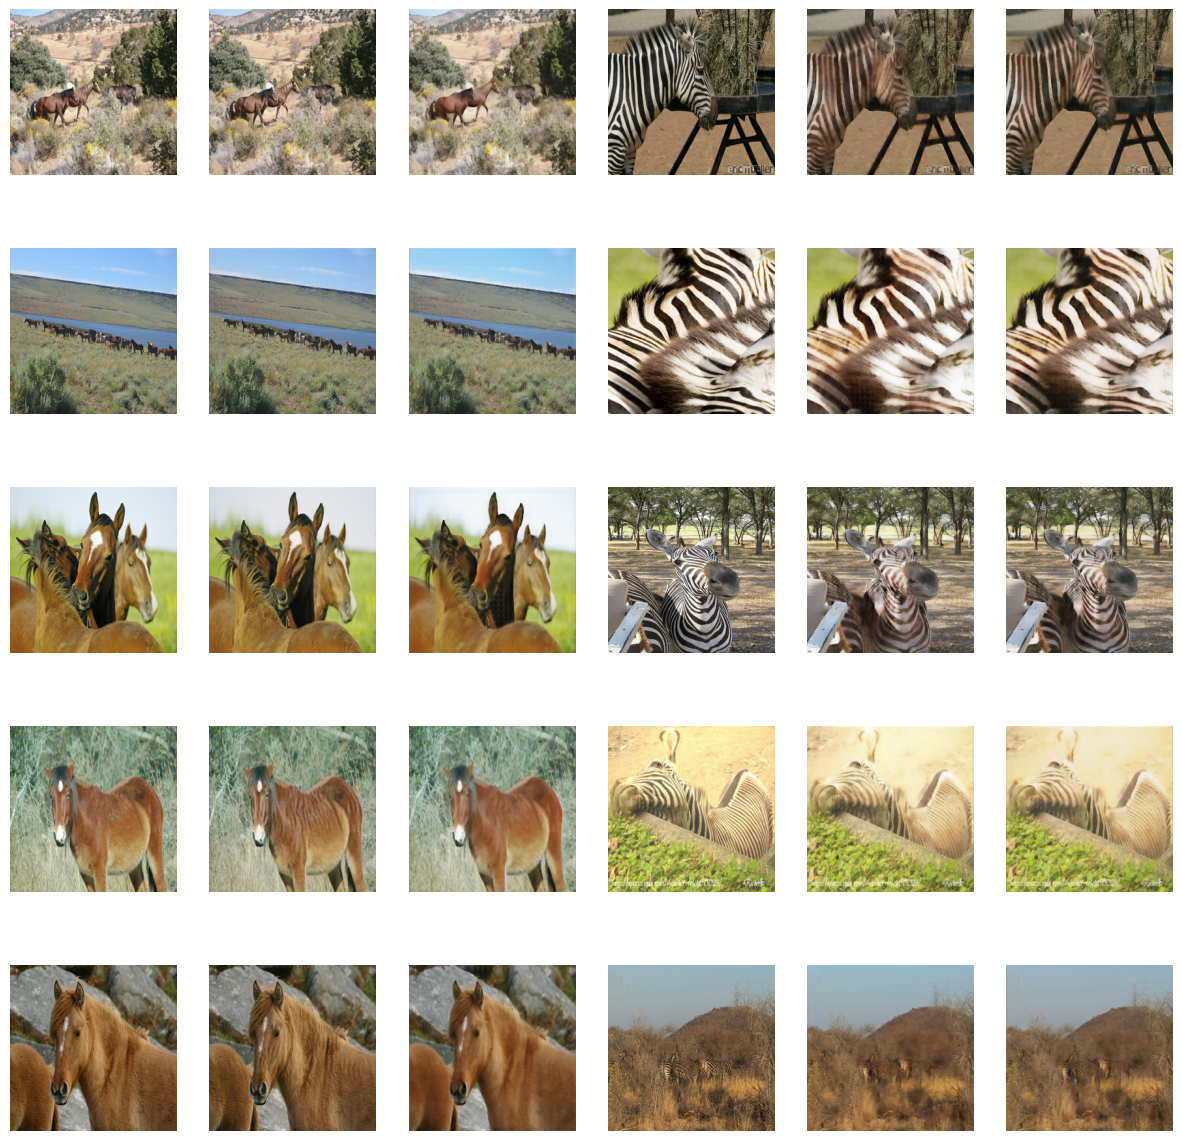

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Load and Prepare the Dataset
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

# Normalize the images to [-1, 1]
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def preprocess_image_train(image, label):
    return normalize(image, label)

def preprocess_image_test(image, label):
    return normalize(image, label)

train_horses = train_horses.map(preprocess_image_train).cache().shuffle(1000).batch(1)
train_zebras = train_zebras.map(preprocess_image_train).cache().shuffle(1000).batch(1)
test_horses = test_horses.map(preprocess_image_test).cache().shuffle(1000).batch(1)
test_zebras = test_zebras.map(preprocess_image_test).cache().shuffle(1000).batch(1)

# Define the Generators
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    up1 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(down3)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.ReLU()(up1)
    up1 = layers.Concatenate()([up1, down2])

    up2 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(up1)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.ReLU()(up2)
    up2 = layers.Concatenate()([up2, down1])

    up3 = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up2)

    return models.Model(inputs=inputs, outputs=up3)

# Define the Discriminators
def build_discriminator():
    inputs = layers.Input(shape=[256, 256, 3])

    down1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    output = layers.Conv2D(1, 4, strides=1)(zero_pad2)

    return models.Model(inputs=inputs, outputs=output)

G = build_generator()
F = build_generator()
D_X = build_discriminator()
D_Y = build_discriminator()

# Define the Loss Functions and Optimizers
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, generated_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    generated_loss = loss_object(tf.zeros_like(generated_output), generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(generated_output):
    return loss_object(tf.ones_like(generated_output), generated_output)

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss

def identity_loss(real_image, same_image, lambda_identity=5):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_identity * loss

G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define the Training Step
@tf.function
def train_step(real_X, real_Y):
    with tf.GradientTape(persistent=True) as tape:
        fake_Y = G(real_X, training=True)
        cycled_X = F(fake_Y, training=True)

        fake_X = F(real_Y, training=True)
        cycled_Y = G(fake_X, training=True)

        same_X = F(real_X, training=True)
        same_Y = G(real_Y, training=True)

        disc_real_X = D_X(real_X, training=True)
        disc_real_Y = D_Y(real_Y, training=True)

        disc_fake_X = D_X(fake_X, training=True)
        disc_fake_Y = D_Y(fake_Y, training=True)

        gen_G_loss = generator_loss(disc_fake_Y)
        gen_F_loss = generator_loss(disc_fake_X)

        total_cycle_loss = cycle_consistency_loss(real_X, cycled_X) + cycle_consistency_loss(real_Y, cycled_Y)

        total_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_Y, same_Y)
        total_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_X, same_X)

        disc_X_loss = discriminator_loss(disc_real_X, disc_fake_X)
        disc_Y_loss = discriminator_loss(disc_real_Y, disc_fake_Y)

    G_gradients = tape.gradient(total_G_loss, G.trainable_variables)
    F_gradients = tape.gradient(total_F_loss, F.trainable_variables)

    D_X_gradients = tape.gradient(disc_X_loss, D_X.trainable_variables)
    D_Y_gradients = tape.gradient(disc_Y_loss, D_Y.trainable_variables)

    G_optimizer.apply_gradients(zip(G_gradients, G.trainable_variables))
    F_optimizer.apply_gradients(zip(F_gradients, F.trainable_variables))

    D_X_optimizer.apply_gradients(zip(D_X_gradients, D_X.trainable_variables))
    D_Y_optimizer.apply_gradients(zip(D_Y_gradients, D_Y.trainable_variables))

    return total_G_loss, total_F_loss, disc_X_loss, disc_Y_loss

# Define the Training Loop
def train(dataset_A, dataset_B, epochs):
    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}/{epochs}')
        for real_X, real_Y in tf.data.Dataset.zip((dataset_A, dataset_B)):
            total_G_loss, total_F_loss, disc_X_loss, disc_Y_loss = train_step(real_X, real_Y)

        clear_output(wait=True)
        generate_and_save_images(G, F, epoch + 1, test_horses, test_zebras)

        print(f'Epoch {epoch+1}: G Loss: {total_G_loss:.4f}, F Loss: {total_F_loss:.4f}, D_X Loss: {disc_X_loss:.4f}, D_Y Loss: {disc_Y_loss:.4f}')

    generate_and_save_images(G, F, epochs, test_horses, test_zebras)

def generate_and_save_images(G, F, epoch, test_input_A, test_input_B):
    # Get sample data from datasets
    test_input_A = list(test_input_A.take(5))
    test_input_B = list(test_input_B.take(5))

    fig, axs = plt.subplots(len(test_input_A), 6, figsize=(15, 15))

    for i in range(len(test_input_A)):
        real_A = test_input_A[i][0]
        real_B = test_input_B[i][0]

        fake_B = G(tf.expand_dims(real_A, 0), training=False)[0]
        cycled_A = F(tf.expand_dims(fake_B, 0), training=False)[0]

        fake_A = F(tf.expand_dims(real_B, 0), training=False)[0]
        cycled_B = G(tf.expand_dims(fake_A, 0), training=False)[0]

        axs[i, 0].imshow((real_A + 1) / 2)
        axs[i, 0].axis('off')
        axs[i, 1].imshow((fake_B + 1) / 2)
        axs[i, 1].axis('off')
        axs[i, 2].imshow((cycled_A + 1) / 2)
        axs[i, 2].axis('off')
        axs[i, 3].imshow((real_B + 1) / 2)
        axs[i, 3].axis('off')
        axs[i, 4].imshow((fake_A + 1) / 2)
        axs[i, 4].axis('off')
        axs[i, 5].imshow((cycled_B + 1) / 2)
        axs[i, 5].axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train and Generate Images
num_examples_to_generate = 5

train(train_horses, train_zebras, epochs=50)

generate_and_save_images(G, F, 50, test_horses, test_zebras)
